In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings(action='once')
import math
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly._subplots as sp

1. Import excel file, this excel file contains the COVID-19 confirmed cases have been recorded daily from 27th April to 24th November 2021.

In [29]:
data = pd.read_excel('data.xlsx')
plot_rawdata = px.line(data,x='Date',y='Confirmed case',title='Recorded confirmed cases times series plot')
plot_rawdata.show()

/home/b/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [30]:
data

,Date,Confirmed case,Vaccination rate,Vaccination coverage,Social Distancing (m),Incubation period (days),Generation time (days)
0,2021-04-27,0,8047,112,2,3.41,2.76
1,2021-04-28,0,7996,111,2,6.02,3.89
2,2021-04-29,1,8043,112,2,7.04,2.51
3,2021-04-30,2,7520,104,2,2.28,0.40
4,2021-05-01,3,7055,98,2,1.16,4.82
...,...,...,...,...,...,...,...
206,2021-11-19,1339,19214,267,2,3.53,5.70
207,2021-11-20,1046,18328,255,1,4.85,4.66
208,2021-11-21,1265,9881,137,1,3.25,0.54
209,2021-11-22,1547,7754,108,1,3.31,1.91


2. The first step in model ARIMA development is considering whether the data is stationary. Hence, an ADF test is provided in the code. From which, d parameters will then be determined based on the stationarity of data in which differencing stage. The COVID-19 confirmed cases in this study is considered to be stationary on the first differencing, which means d = 1 in ARIMA model

In [31]:
# ADF Test
# Considering whether the raw data is stationary or not
confirmedcase_raw = data['Confirmed case'].values
raw_adf_test = adfuller(confirmedcase_raw)

print('The result of ADF test of raw data is:')

print('ADF Statistic: %f' % raw_adf_test[0])

print('p-value: %f' % raw_adf_test[1])

print('Critical values:')
for key,value in raw_adf_test[4].items():
    print(key,value)

if raw_adf_test[0] < raw_adf_test[4]['5%']:
    print('Reject H0 - Time Series is Stationary')
else:
    print('Failed to Reject H0 - Time Series is Non-Stationary')

The result of ADF test of raw data is:
ADF Statistic: -1.512470
p-value: 0.527334
Critical values:
1% -3.462980134086401
5% -2.875885461947131
10% -2.5744164898444515
Failed to Reject H0 - Time Series is Non-Stationary


In [32]:
# ADF Test
# Considering whether the 1st differencing data is stationary or not
data['1st Differencing'] = data['Confirmed case'] - data['Confirmed case'].shift(1)
data['1st Differencing'] = data['1st Differencing'].fillna(0)
data['1st Differencing'] = data['1st Differencing'].astype(int)

plot_1stdata = px.line(data,x='Date',y='1st Differencing',title='1st Differencing Data cases times series plot')
plot_1stdata.show()

confirmedcase_1st = data['1st Differencing'].values
first_adf_test = adfuller(confirmedcase_1st)

print('The result of ADF test of raw data is:')

print('ADF Statistic: %f' % first_adf_test[0])

print('p-value: %f' % first_adf_test[1])

print('Critical values:')
for key,value in first_adf_test[4].items():
    print(key,value)

if first_adf_test[0] < first_adf_test[4]['5%']:
    print('Reject H0 - Time Series is Stationary')
else:
    print('Failed to Reject H0 - Time Series is Non-Stationary')

/home/b/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



The result of ADF test of raw data is:
ADF Statistic: -5.318863
p-value: 0.000005
Critical values:
1% -3.462818103072159
5% -2.8758145932936805
10% -2.574378674548251
Reject H0 - Time Series is Stationary


In [33]:
data[['Date','Confirmed case','1st Differencing']]

,Date,Confirmed case,1st Differencing
0,2021-04-27,0,0
1,2021-04-28,0,0
2,2021-04-29,1,1
3,2021-04-30,2,1
4,2021-05-01,3,1
...,...,...,...
206,2021-11-19,1339,-270
207,2021-11-20,1046,-293
208,2021-11-21,1265,219
209,2021-11-22,1547,282


3. AR(p) and MA(q) were determined using ACF and PACF method

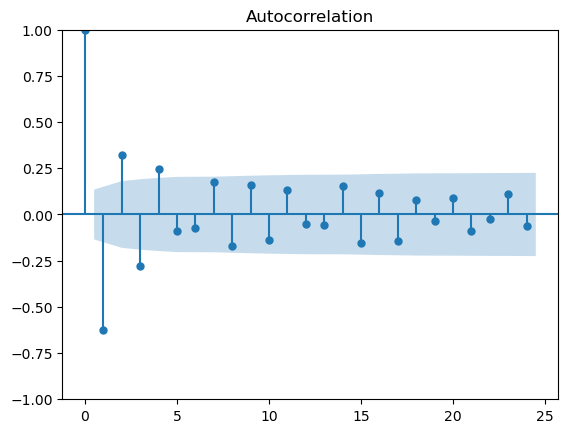

In [34]:
acf_plot = plot_acf(data['1st Differencing'].dropna())

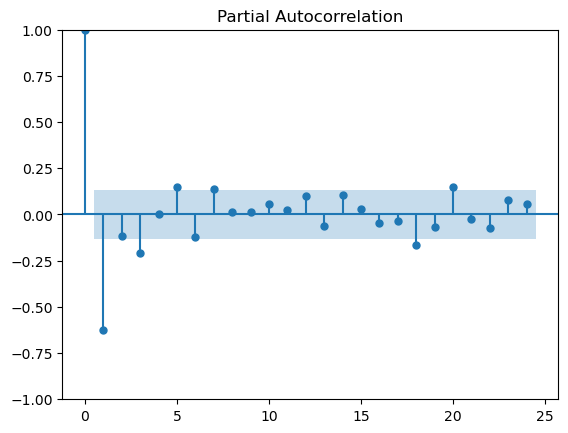

In [35]:
pacf_plot = plot_pacf(data['1st Differencing'].dropna(),method='ywm')

4. To implement the external parameters into the model, the study uses Pearson’s correlation to determine the relationships between Confirmed cases and external data defined. However, since the correlation can easily be calculated through excel, the following code only considers when the Beta parameters of external data have been defined and implement these parameters into the ARIMA model for simplicity:

In [36]:
vaccination = data['Vaccination coverage'].values
social_distance = data['Social Distancing (m)'].values
incubation = data['Incubation period (days)'].values
generation_time = data['Generation time (days)'].values

beta_vaccination = 0.361
beta_distancing = 0.577
beta_incubation = -0.03
beta_genaration = 0.092

x1 = beta_vaccination * vaccination
x2 = beta_distancing * social_distance
x3 = beta_incubation * incubation
x4 = beta_genaration * generation_time

data['External'] = x1 + x2 + x3 + x4
data['External']

0       41.73762
1       41.40228
2       41.60572
3       38.66640
4       36.94064
         ...    
206     97.95950
207     92.91522
208     49.98618
209     39.64142
210    116.89294
Name: External, Length: 211, dtype: float64

5. The ARIMA parameters and external parameters were used to forecast the COVID-19 confirmed cases in this stage, the following code provides a way to plot these data and include the real data for fitting. Noted that in this stage, a 95% confidence level is applied for COVID-19 confirmed cases collected

In [37]:
# ARIMA model: provide a forecasting model ARIMA --> ARIMA (1,1,0)
model = ARIMA(data['Confirmed case'],order=(1,1,0))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Confirmed case   No. Observations:                  211
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1687.058
Date:                Fri, 10 Feb 2023   AIC                           3378.117
Time:                        16:56:55   BIC                           3384.811
Sample:                             0   HQIC                          3380.823
                                - 211                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6260      0.031    -20.099      0.000      -0.687      -0.565
sigma2      5.583e+05   3.01e+04     18.543      0.000    4.99e+05    6.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):               186.55
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):              41.01   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
df_residuals = pd.DataFrame(result.resid)

df_residuals.columns = ['Residuals']
df_residuals

,Residuals
0,0.000000
1,0.000000
2,1.000000
3,1.626001
4,1.626001
...,...
206,-99.727674
207,-462.020323
208,35.581649
209,419.094262


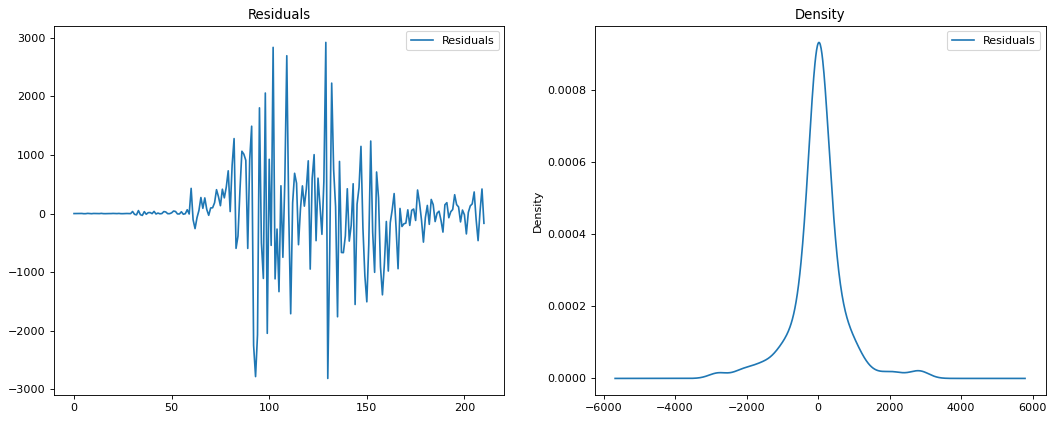

In [39]:
fig2,ax = plt.subplots(1,2,figsize=(16,6),dpi=80)

df_residuals.plot(title='Residuals',ax=ax[0])
df_residuals.plot(title='Density',ax=ax[1],kind='kde')
plt.show()

In [40]:
# Summary stats of residuals
df_residuals.describe()

,Residuals
count,211.000000
mean,10.295848
std,745.370968
min,-2812.200952
25%,-139.528960
50%,1.626001
75%,183.659593
max,2919.096713


In [41]:
data['ARIMA(1,1,0)'] = result.predict(start=0,end=211,dynamic=False)
data['ARIMA(1,1,0)'] = data['ARIMA(1,1,0)'].astype(int)
data['Final Forecast Result'] = data['ARIMA(1,1,0)'] + data['External']
data['Final Forecast Result'] = data['Final Forecast Result'].astype(int)
data

,Date,Confirmed case,Vaccination rate,Vaccination coverage,Social Distancing (m),Incubation period (days),Generation time (days),1st Differencing,External,"ARIMA(1,1,0)",Final Forecast Result
0,2021-04-27,0,8047,112,2,3.41,2.76,0,41.73762,0,41
1,2021-04-28,0,7996,111,2,6.02,3.89,0,41.40228,0,41
2,2021-04-29,1,8043,112,2,7.04,2.51,1,41.60572,0,41
3,2021-04-30,2,7520,104,2,2.28,0.40,1,38.66640,0,38
4,2021-05-01,3,7055,98,2,1.16,4.82,1,36.94064,1,37
...,...,...,...,...,...,...,...,...,...,...,...
206,2021-11-19,1339,19214,267,2,3.53,5.70,-270,97.95950,1438,1535
207,2021-11-20,1046,18328,255,1,4.85,4.66,-293,92.91522,1508,1600
208,2021-11-21,1265,9881,137,1,3.25,0.54,219,49.98618,1229,1278
209,2021-11-22,1547,7754,108,1,3.31,1.91,282,39.64142,1127,1166


In [42]:
# 95% Confidence interval
CI = 1.96 * np.std(data['Confirmed case']) / np.sqrt(len(list(data['Date'])))

# Plot
import plotly.express as px
import plotly.graph_objs as go

# First trace
actual = go.Scatter(x=data['Date'], y=data['Confirmed case'],
                    name='COVID-19 Confirmed Cases')

# Second trace
arima110 = go.Scatter(x=data['Date'], y=data['Final Forecast Result'],
                    name='ARIMA(1,1,0) Forecast')

# Fill between trace
conf_int1 = go.Scatter(x=data['Date'], y=(data['Confirmed case'] + CI), fill='tonexty',
                        opacity=0.5, line=dict(width=0), name='CI fill upper')
conf_int2 = go.Scatter(x=data['Date'], y=(data['Confirmed case'] - CI), fill='tonexty',
                        opacity=0.5, line=dict(width=0), name='CI fill lower')

# Create the figure
result_fig = go.Figure(data=[actual, arima110, conf_int1, conf_int2], layout=go.Layout(
    title='Forecast of COVID-19 Confirmed Cases in HCMC',
    xaxis=dict(title='Date'),
    yaxis=dict(title='COVID-19 Cases'),
    # plot_bgcolor='white',  # set the plot background color to white
    # paper_bgcolor='white'  # set the paper background color to white
))

# Show the figure
result_fig.show()


/home/b/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



6. After providing forecast results, the study continued with calculating and plotting a 7-day moving average between forecasting results and real data. MSE and RMSE calculation was also included in this part for error comparison in this study:

In [43]:
"""Calculate the 7-day Moving Average of both confirmed cases and forecasting result"""

# For confirmed cases
window_size1 = 7
i = 0
moving_avg_acutal = []
# Loop through array to consider every window of size 7:
while i < len(data['Confirmed case']) - window_size1 + 1:
    actual_list = list(data['Confirmed case'])
    # Store elements from i to i+window_size in list to get the current window
    window1 = actual_list[i:i+window_size1]
    # Calculate the avg of the current window
    window_average_actual = round(sum(window1)/window_size1, 2)
    # Store the avg of the current window in moving average list
    moving_avg_acutal.append(window_average_actual)

    i=i+1

In [44]:
# For forcasting cases
window_size2 = 7
j = 0
moving_avg_forecast = []
# Loop through array to consider every window of size 7:
while j < len(data['Final Forecast Result']) - window_size2 + 1:
    forecast_list = list(data['Final Forecast Result'])
    # Store elements from i to i+window_size in list to get the current window
    window2 = forecast_list[j:j+window_size2]
    # Calculate the avg of the current window
    window_average_forecast = round(sum(window2)/window_size2, 2)
    # Store the avg of the current window in moving average list
    moving_avg_forecast.append(window_average_forecast)

    j=j+1

In [45]:
moving_avg_acutal = pd.DataFrame(moving_avg_acutal)
moving_avg_acutal.columns = ['7-day Moving Average Actual']
moving_avg_acutal

,7-day Moving Average Actual
0,0.86
1,1.29
2,1.43
3,1.29
4,1.29
...,...
200,1265.43
201,1237.71
202,1277.71
203,1332.29


In [46]:
moving_avg_forecast = pd.DataFrame(moving_avg_forecast)
moving_avg_forecast.columns = ['7-day Moving Average Forecast']
moving_avg_forecast

,7-day Moving Average Forecast
0,36.00
1,31.00
2,26.43
3,22.29
4,18.29
...,...
200,1333.71
201,1364.43
202,1346.71
203,1346.29


In [47]:
# Specify the number of observation in 7-day moving average --> 205 obs
mva_obs = np.linspace(0,204,205)
mva_obs = pd.DataFrame(mva_obs)
mva_obs.columns = ['Index Order']
mva_obs['Index Order'] = mva_obs['Index Order'].astype(int)
mva_obs

,Index Order
0,0
1,1
2,2
3,3
4,4
...,...
200,200
201,201
202,202
203,203


In [50]:
# 95% Confidence interval
mva_CI = 1.96 * np.std(moving_avg_acutal['7-day Moving Average Actual']) / np.sqrt(len(list(mva_obs['Index Order'])))

# First trace
mva_actual = go.Scatter(x=mva_obs['Index Order'], y=moving_avg_acutal['7-day Moving Average Actual'],
                    name='7-day Moving Average COVID-19 Confirmed Cases')

# Second trace
mva_arima110 = go.Scatter(x=mva_obs['Index Order'], y=moving_avg_forecast['7-day Moving Average Forecast'],
                    name='7-day Moving Average ARIMA(1,1,0) Forecast')

# Fill between trace
mva_conf_int1 = go.Scatter(x=mva_obs['Index Order'], y=(moving_avg_acutal['7-day Moving Average Actual']) + mva_CI, fill='tonexty',
                        opacity=0.5, line=dict(width=0), name='CI fill upper')
mva_conf_int2 = go.Scatter(x=mva_obs['Index Order'], y=(moving_avg_acutal['7-day Moving Average Actual']) - mva_CI, fill='tonexty',
                        opacity=0.5, line=dict(width=0), name='CI fill lower')

# Create the figure
mva_fig = go.Figure(data=[mva_actual, mva_arima110, mva_conf_int1, mva_conf_int2], layout=go.Layout(
    title='7-day Moving Average Forecast of COVID-19 Confirmed Cases in HCMC',
    xaxis=dict(title='Index Order'),
    yaxis=dict(title='7-day Moving Average Cases'),
    # plot_bgcolor='white',  # set the plot background color to white
    paper_bgcolor='white'  # set the paper background color to white
))

# Show the figure
mva_fig.show()


In [51]:
# RMSE Calculation
MSE = np.square(np.subtract(data['Confirmed case'],data['Final Forecast Result'])).mean()
RMSE = math.sqrt(MSE)

print('Mean Square Error (MSE): ',MSE)
print('Root Mean Square Error (RMSE): ',RMSE)

Mean Square Error (MSE):  952224.0663507109
Root Mean Square Error (RMSE):  975.8196894666099
